# Generating time series features with xr_fresh

This notebook demonstrates how to generate time series features using the `xr_fresh` library. The library is designed to work with rasters, xarray datasets and data arrays, and it provides a simple and flexible way to generate features from time series data.

In [1]:
import geowombat as gw
import os
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
os.getcwd()

/home/mmann1123/miniconda3/envs/xr_fresh_update/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'/home/mmann1123/Documents/github/xr_fresh/notebooks'

### Read in data and sort by date 

In [2]:
# change working directory
os.chdir('../xr_fresh/data/')

band_name = 'ppt'  # used to rename outputs
file_glob = f"pdsi*tif"
strp_glob = f"pdsi_%Y%m_4500m.tif"

dates = sorted(datetime.strptime(string, strp_glob)
        for string in sorted(glob(file_glob)))
files = sorted(glob(file_glob))

# print dates and files in a table
pd.DataFrame({'date': dates, 'file': files})


,date,file
0,2018-01-01,pdsi_201801_4500m.tif
1,2018-02-01,pdsi_201802_4500m.tif
2,2018-03-01,pdsi_201803_4500m.tif
3,2018-04-01,pdsi_201804_4500m.tif
4,2018-05-01,pdsi_201805_4500m.tif
5,2018-06-01,pdsi_201806_4500m.tif
6,2018-07-01,pdsi_201807_4500m.tif
7,2018-08-01,pdsi_201808_4500m.tif
8,2018-09-01,pdsi_201809_4500m.tif
9,2018-10-01,pdsi_201810_4500m.tif


Now we will open the data to see what it looks like using `geowombat`, see docs [here](https://geowombat.readthedocs.io/). 

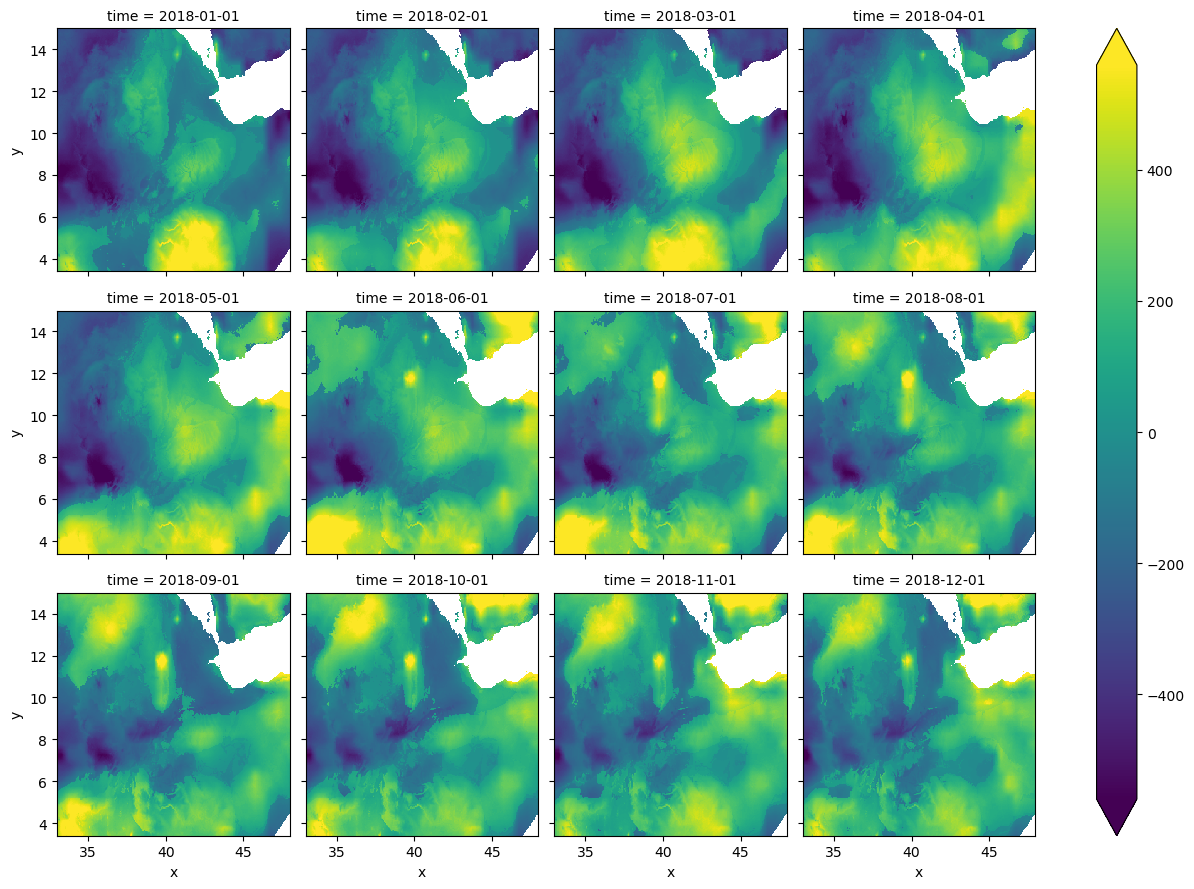

In [3]:
# open xarray
with gw.open(files, 
             band_names=[band_name],
             time_names = dates,nodata=-9999  ) as ds:
    ds = ds.gw.mask_nodata()
    ds.plot(col='time', col_wrap=4, cmap='viridis', robust=True)

### Calculate the longest consecutive streak of days above the mean

In [4]:
%%time
# make temp folder
import tempfile
from pathlib import Path
temp_dir = Path(tempfile.mkdtemp())

from xr_fresh.feature_calculator_series import longest_strike_below_mean


out_path = os.path.join(temp_dir, 'longest_strike_above_mean.tif')
# use rasterio to create a new file tif file

with gw.series(files,window_size=[256, 256]) as src:
    src.apply(
        longest_strike_below_mean(),
        bands=1,
        num_workers=12,
        outfile=out_path,
    )

100%|██████████| 4/4 [00:00<00:00, 13.26it/s]

CPU times: user 568 ms, sys: 178 ms, total: 747 ms
Wall time: 597 ms


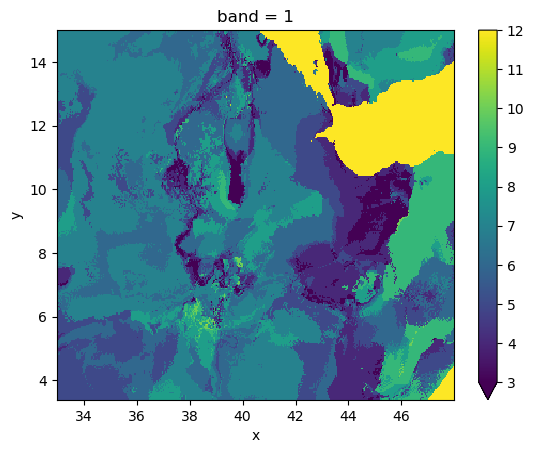

In [5]:
with gw.open(out_path) as ds:
    ds.plot(robust=True)
    plt.show()

### Generate time series features stack

In [6]:
# create list of desired series
feature_list = {
    "minimum": [{}],
    "abs_energy": [{}],
    "doy_of_maximum": [{"dates": dates}],
    "mean_abs_change": [{}],
    "ratio_beyond_r_sigma": [{"r": 1}, {"r": 2}],
    "symmetry_looking": [{}],
    "sum": [{}],
    "quantile": [{"q": 0.05}, {"q": 0.95}],
}

In [7]:
from xr_fresh.extractors_series import extract_features_series

# Extract features from the geospatial time series
extract_features_series(files, feature_list, band_name, temp_dir, num_workers=12, nodata=-9999)

100%|██████████| 4/4 [00:00<00:00, 5141.65it/s]


In [8]:
features = sorted(glob(os.path.join(temp_dir, "*.tif")))
feature_names = [os.path.basename(f).split(".")[0] for f in features]

pd.DataFrame({'feature': feature_names, 'file': features})

,feature,file
0,longest_strike_above_mean,/tmp/tmp6bv2fvf7/longest_strike_above_mean.tif
1,ppt_abs_energy,/tmp/tmp6bv2fvf7/ppt_abs_energy.tif
2,ppt_doy_of_maximum_dates,/tmp/tmp6bv2fvf7/ppt_doy_of_maximum_dates.tif
3,ppt_mean_abs_change,/tmp/tmp6bv2fvf7/ppt_mean_abs_change.tif
4,ppt_minimum,/tmp/tmp6bv2fvf7/ppt_minimum.tif
5,ppt_quantile_q_0,/tmp/tmp6bv2fvf7/ppt_quantile_q_0.05.tif
6,ppt_quantile_q_0,/tmp/tmp6bv2fvf7/ppt_quantile_q_0.95.tif
7,ppt_ratio_beyond_r_sigma_r_1,/tmp/tmp6bv2fvf7/ppt_ratio_beyond_r_sigma_r_1.tif
8,ppt_ratio_beyond_r_sigma_r_2,/tmp/tmp6bv2fvf7/ppt_ratio_beyond_r_sigma_r_2.tif
9,ppt_sum,/tmp/tmp6bv2fvf7/ppt_sum.tif


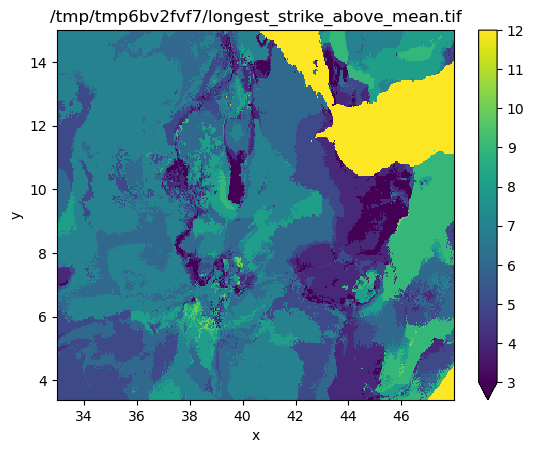

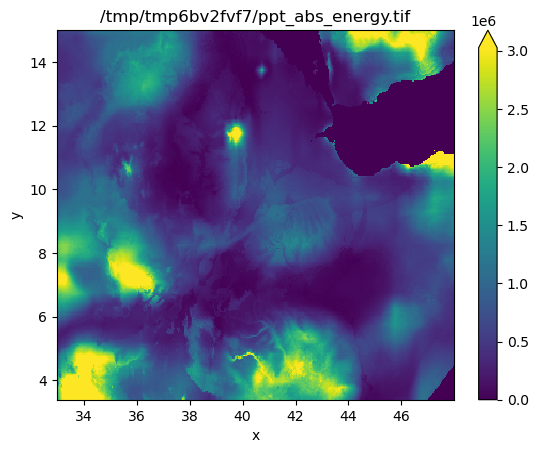

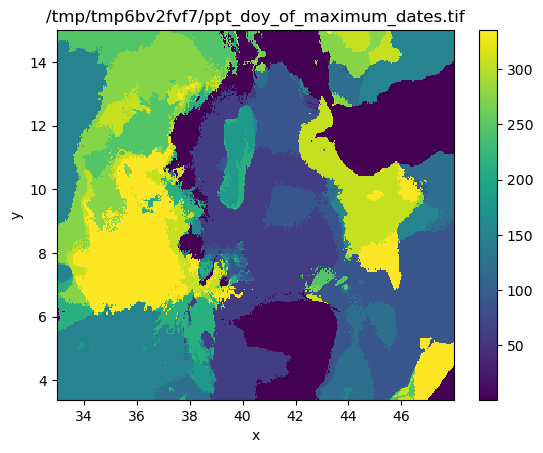

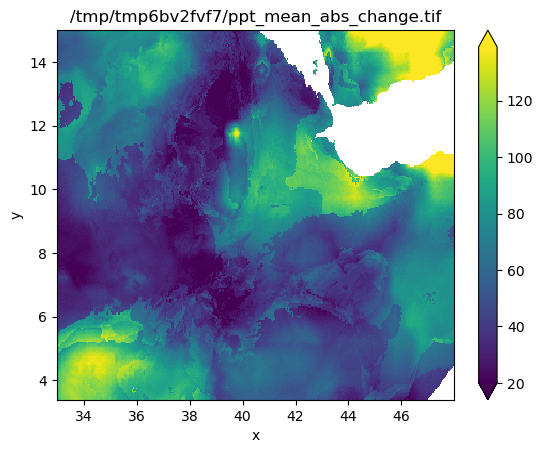

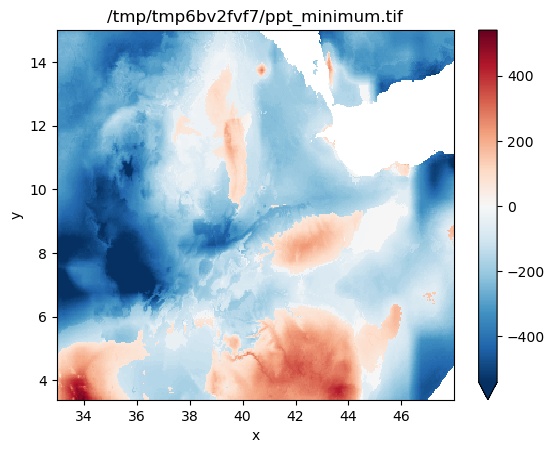

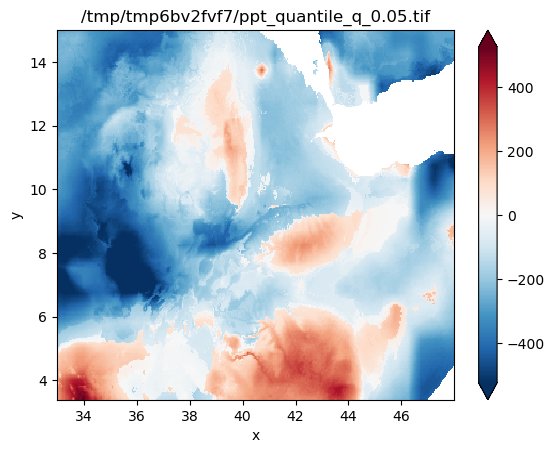

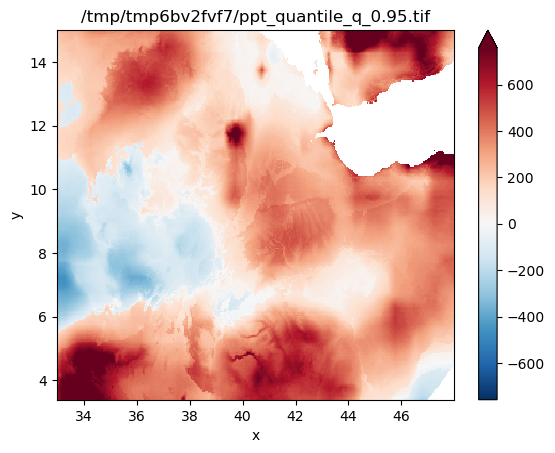

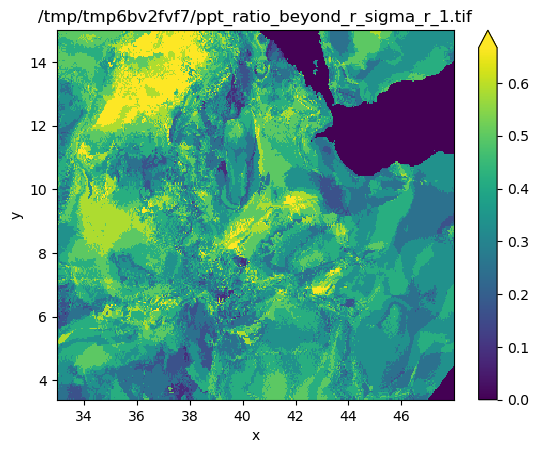

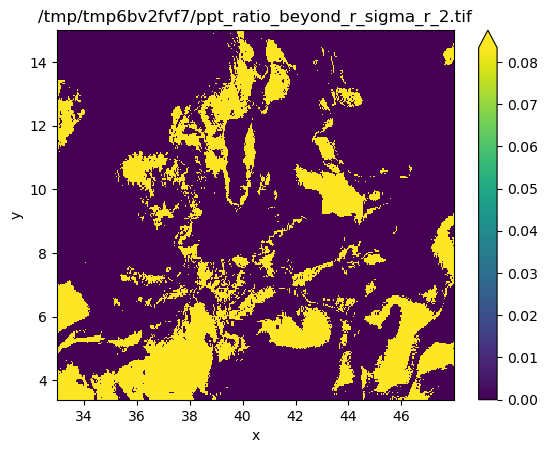

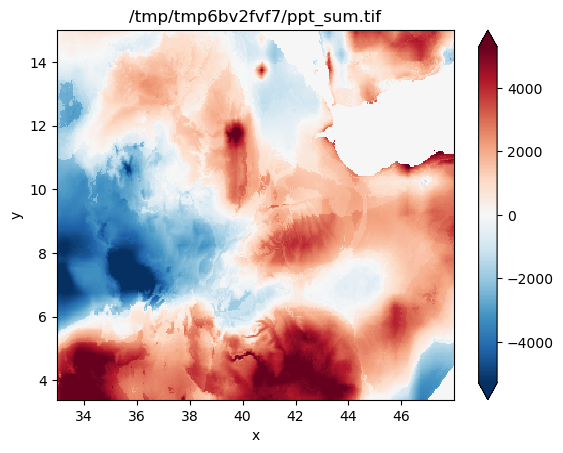

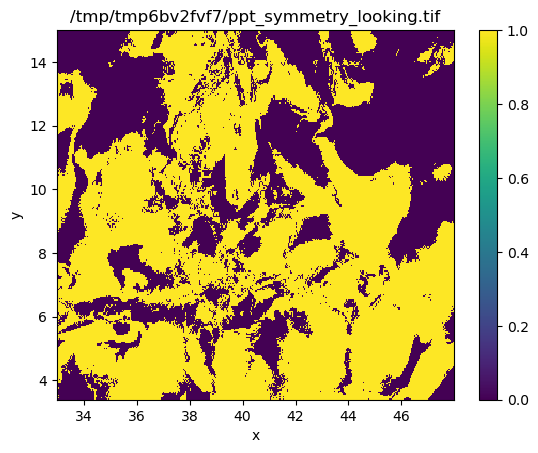

In [9]:
# Plot all files in the temp directory with title as file name in rasterio
for file in features:
    with gw.open(file) as ds:
        ds.plot(robust=True)
        plt.title(file)
        plt.show()

In [10]:
 # clean up temp directory
import shutil
shutil.rmtree(temp_dir)
